### **IMPORTING** **NECESSARY** **LIBRARIES**

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### **LOADING THE TRAINING AND TESTING DATA INTO PANDAS DATAFRAME**

In [2]:
train_df = pd.read_csv('propaganda_train.tsv', sep='\t') ### loading training data
test_df = pd.read_csv('propaganda_val.tsv', sep='\t') ### loading testing data


In [3]:
print(train_df.head()) ### printing first 5 rows of training dataset

            label                                  tagged_in_context
0  not_propaganda         No, <BOS> he <EOS> will not be confirmed. 
1  not_propaganda  This declassification effort <BOS> won’t make ...
2     flag_waving  The Obama administration misled the <BOS> Amer...
3  not_propaganda  “It looks like we’re capturing the demise of t...
4  not_propaganda           <BOS> Location: Westerville, Ohio <EOS> 


In [4]:
print(test_df.head()) ### printing first 5 rows of testing dataset

                       label  \
0             not_propaganda   
1  causal_oversimplification   
2   appeal_to_fear_prejudice   
3             not_propaganda   
4                 repetition   

                                   tagged_in_context  
0  On average, between 300 and 600 infections are...  
1  Mostly because <BOS> the country would not las...  
2  Lyndon Johnson <BOS> gets Earl Warren and Sen....  
3           <BOS> You <EOS> may opt out at anytime.   
4  It must be exacted from him directly in order ...  


In [5]:
print(train_df.tail())  ### printing last 5 rows of training dataset

                      label                                  tagged_in_context
2409         not_propaganda  <BOS> We support and appreciate <EOS> your bus...
2410         not_propaganda  International Atomic Energy Agency (IAEA) Dire...
2411         not_propaganda  What has been done: there has been work on for...
2412         not_propaganda  This is <BOS> the law of gradualness not the g...
2413  name_calling,labeling  In it, Jews are described as: “arrogant,” “jea...


In [6]:
print(test_df.tail()) ### printing last 5 rows of testing dataset

                         label  \
575             not_propaganda   
576             not_propaganda   
577             not_propaganda   
578                flag_waving   
579  causal_oversimplification   

                                     tagged_in_context  
575  NewsCatholic Church, <BOS> Family, Marriage <E...  
576  Remember our saying, modern day fairy <BOS> ta...  
577  Why <BOS> not <EOS> open up to Iran with massi...  
578  <BOS> He also sang an Islamic State fight song...  
579  We hear again, as we did incessantly from the ...  


In [7]:
train_df.columns = ['label', 'sentence'] ### replacing the tagged_in_context with sentence for training dataset
test_df.columns = ['label', 'sentence'] ### replacing the tagged_in_context with sentence for testing dataset

In [8]:
train_df.head() ### seeing whether it got changed in training dataset

,label,sentence
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [9]:
test_df.head() ### seeing whether it got changed in testing dataset

,label,sentence
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...


### **EXTRACTING** **TEXT** **BETWEEN** **BOS** **AND** **EOS** **AND** **STORING** **IN** **SPAN** **FOR** **BOTH** **TRAINING** **AND** **TESTING** **DATA** **USING** **FUNCTION** **RE**.**SEARCH**()

In [10]:
train_df["span"] = [re.search("(?<=<BOS>)(.*)(?=<EOS>)", x).group().strip() if ("<BOS>" in x and "<EOS>" in x) else "" for x in train_df["sentence"]]
test_df["span"] = [re.search("(?<=<BOS>)(.*)(?=<EOS>)", x).group().strip() if ("<BOS>" in x and "<EOS>" in x) else "" for x in test_df["sentence"]]


In [11]:
train_df #checking

,label,sentence,span
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",he
1,not_propaganda,This declassification effort <BOS> won’t make ...,won’t make things any worse than they are for ...
2,flag_waving,The Obama administration misled the <BOS> Amer...,American people
3,not_propaganda,“It looks like we’re capturing the demise of t...,and
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>","Location: Westerville, Ohio"
...,...,...,...
2409,not_propaganda,<BOS> We support and appreciate <EOS> your bus...,We support and appreciate
2410,not_propaganda,International Atomic Energy Agency (IAEA) Dire...,capacity to check whether Iran was conducting ...
2411,not_propaganda,What has been done: there has been work on for...,one for those recently
2412,not_propaganda,This is <BOS> the law of gradualness not the g...,the law of gradualness not the gradualness of ...


In [12]:
test_df #checking

,label,sentence,span
0,not_propaganda,"On average, between 300 and 600 infections are...",according to a UN estimate.
1,causal_oversimplification,Mostly because <BOS> the country would not las...,the country would not last long without an out...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,gets Earl Warren and Sen. Richard Russel to jo...
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.,You
4,repetition,It must be exacted from him directly in order ...,infidels
...,...,...,...
575,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E...","Family, Marriage"
576,not_propaganda,"Remember our saying, modern day fairy <BOS> ta...",tales start with ‘once I am
577,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...,not
578,flag_waving,<BOS> He also sang an Islamic State fight song...,He also sang an Islamic State fight song and r...


In [13]:
train_df['tokens'] = train_df['span'].apply(lambda x: nltk.word_tokenize(x)) #tokenizing
test_df['tokens'] = test_df['span'].apply(lambda x: nltk.word_tokenize(x))

In [14]:
train_df

,label,sentence,span,tokens
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",he,[he]
1,not_propaganda,This declassification effort <BOS> won’t make ...,won’t make things any worse than they are for ...,"[won, ’, t, make, things, any, worse, than, th..."
2,flag_waving,The Obama administration misled the <BOS> Amer...,American people,"[American, people]"
3,not_propaganda,“It looks like we’re capturing the demise of t...,and,[and]
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>","Location: Westerville, Ohio","[Location, :, Westerville, ,, Ohio]"
...,...,...,...,...
2409,not_propaganda,<BOS> We support and appreciate <EOS> your bus...,We support and appreciate,"[We, support, and, appreciate]"
2410,not_propaganda,International Atomic Energy Agency (IAEA) Dire...,capacity to check whether Iran was conducting ...,"[capacity, to, check, whether, Iran, was, cond..."
2411,not_propaganda,What has been done: there has been work on for...,one for those recently,"[one, for, those, recently]"
2412,not_propaganda,This is <BOS> the law of gradualness not the g...,the law of gradualness not the gradualness of ...,"[the, law, of, gradualness, not, the, gradualn..."


In [15]:
test_df

,label,sentence,span,tokens
0,not_propaganda,"On average, between 300 and 600 infections are...",according to a UN estimate.,"[according, to, a, UN, estimate, .]"
1,causal_oversimplification,Mostly because <BOS> the country would not las...,the country would not last long without an out...,"[the, country, would, not, last, long, without..."
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,gets Earl Warren and Sen. Richard Russel to jo...,"[gets, Earl, Warren, and, Sen., Richard, Russe..."
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.,You,[You]
4,repetition,It must be exacted from him directly in order ...,infidels,[infidels]
...,...,...,...,...
575,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E...","Family, Marriage","[Family, ,, Marriage]"
576,not_propaganda,"Remember our saying, modern day fairy <BOS> ta...",tales start with ‘once I am,"[tales, start, with, ‘, once, I, am]"
577,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...,not,[not]
578,flag_waving,<BOS> He also sang an Islamic State fight song...,He also sang an Islamic State fight song and r...,"[He, also, sang, an, Islamic, State, fight, so..."


### **COVERTING** **THE** **LABELS** **FOR** **BINARY** **CLASSIFICATION**

In [16]:
label_map = {"not_propaganda": "not_propaganda", "flag_waving": "propaganda", "appeal_to_fear_prejudice": "propaganda", "causal_oversimplification": "propaganda", "doubt": "propaganda", "exaggeration,minimisation": "propaganda", "loaded_language": "propaganda", "name_calling,labeling": "propaganda", "repetition": "propaganda"}

train_df["propaganda_classification"] = train_df["label"].map(label_map)
test_df["propaganda_classification"] = test_df["label"].map(label_map)   ### labelling as propaganda or not propaganda



In [17]:
train_df.head() #checking

,label,sentence,span,tokens,propaganda_classification
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",he,[he],not_propaganda
1,not_propaganda,This declassification effort <BOS> won’t make ...,won’t make things any worse than they are for ...,"[won, ’, t, make, things, any, worse, than, th...",not_propaganda
2,flag_waving,The Obama administration misled the <BOS> Amer...,American people,"[American, people]",propaganda
3,not_propaganda,“It looks like we’re capturing the demise of t...,and,[and],not_propaganda
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>","Location: Westerville, Ohio","[Location, :, Westerville, ,, Ohio]",not_propaganda


In [18]:
test_df.head() #checking

,label,sentence,span,tokens,propaganda_classification
0,not_propaganda,"On average, between 300 and 600 infections are...",according to a UN estimate.,"[according, to, a, UN, estimate, .]",not_propaganda
1,causal_oversimplification,Mostly because <BOS> the country would not las...,the country would not last long without an out...,"[the, country, would, not, last, long, without...",propaganda
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,gets Earl Warren and Sen. Richard Russel to jo...,"[gets, Earl, Warren, and, Sen., Richard, Russe...",propaganda
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.,You,[You],not_propaganda
4,repetition,It must be exacted from him directly in order ...,infidels,[infidels],propaganda


### **TASK** **1**: **BUILD** **AND** **EVALUATE** **AT** **LEAST** **2** **APPROACHES** **TO** **CLASSIFY** **WHETHER** **A** **SENTENCE** **CONTAINS** **PROPAGANDA** **OR** **NOT**.

### **TASK** **1** **USING** **N**  **GRAM** **LANGUAGE** **MODELS**

In [19]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_df['span'], train_df['propaganda_classification'], test_size=0.2, random_state=42)

In [20]:
# Converting text to n-grams
vectorizer = CountVectorizer(ngram_range=(1,3))
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)


In [21]:
# Training a Multinomial Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train_vect, y_train)


MultinomialNB()

In [22]:
# Evaluating the classifier
y_pred = clf.predict(X_test_vect)

In [23]:
print("Accuracy:", accuracy_score(y_test, y_pred)) # Calculating evaluation metrics
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.6459627329192547
Precision: 0.6990149825826674
Recall: 0.6459627329192547
F1-score: 0.6203152925338051


In [24]:
# Creating confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['propaganda', 'not_propaganda'])
cm





array([[219,  23],
       [148,  93]])

<Axes: >

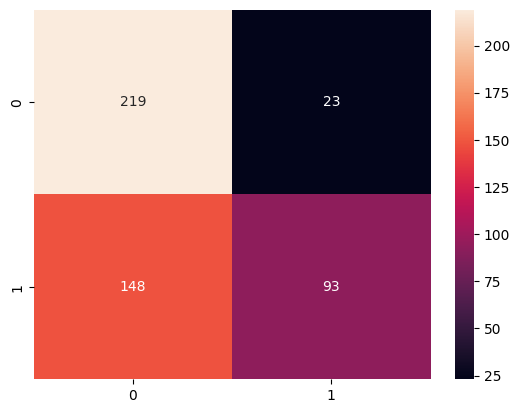

In [25]:
# Visualizing the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")

### **TASK** **1**  **USING** **WORD2VEC**

In [26]:
# Splitting the dataset into training and test sets
X_train = train_df["sentence"]
y_train = train_df["propaganda_classification"]
X_test = test_df["sentence"]
y_test = test_df["propaganda_classification"]


In [27]:
# Defining the maximum sequence length
max_sequence_length = 100

In [28]:
#Using a for-loop to iterate over the words in the sentence to check if they are present in the word2vec model vocabulary before adding their respective word vectors to the word_vectors list. Then I used np.pad to add zero padding to the sentence vector if its length is less than max_sequence_length. Finally, returns the sentence vector truncated to max_sequence_length
def sentence_vector(sentence, model, max_sequence_length):
    words = sentence.split()
    word_vectors = []
    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if not word_vectors:
        return np.zeros((max_sequence_length,))
    sentence_vector = np.mean(word_vectors, axis=0)
    if len(sentence_vector) < max_sequence_length:
        sentence_vector = np.pad(sentence_vector, ((0, max_sequence_length - len(sentence_vector))), mode='constant', constant_values=0)
    return sentence_vector[:max_sequence_length]

In [29]:
w2v_model = Word2Vec(train_df["tokens"], vector_size=100, window=5, 
min_count=1, workers=4)

In [30]:
max_sequence_length = 100

X_train_w2v = np.array([sentence_vector(sentence, w2v_model, max_sequence_length) for sentence in X_train])
X_test_w2v = np.array([sentence_vector(sentence, w2v_model, max_sequence_length) for sentence in X_test])

In [31]:
w2v_classifier = LogisticRegression() # Training Logistic Regression classifier
w2v_classifier.fit(X_train_w2v, y_train) 


LogisticRegression()

In [32]:
y_pred = w2v_classifier.predict(X_test_w2v) # Evaluating the classifier


In [33]:
# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,  pos_label='propaganda')
recall = recall_score(y_test, y_pred,  pos_label='propaganda')
f1 = f1_score(y_test, y_pred,  pos_label='propaganda')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Accuracy: 0.5189655172413793
Precision: 0.5
Recall: 0.7849462365591398
F1 score: 0.6108786610878661


In [34]:
# Creating confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['propaganda', 'not_propaganda'])
cm

array([[219,  60],
       [219,  82]])

<Axes: >

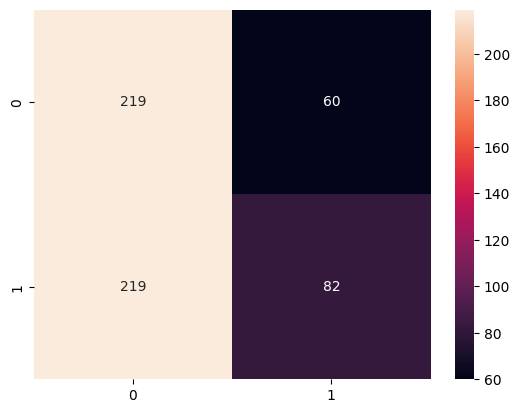

In [35]:
# Visualizing the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")

In [36]:
train_df


,label,sentence,span,tokens,propaganda_classification
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",he,[he],not_propaganda
1,not_propaganda,This declassification effort <BOS> won’t make ...,won’t make things any worse than they are for ...,"[won, ’, t, make, things, any, worse, than, th...",not_propaganda
2,flag_waving,The Obama administration misled the <BOS> Amer...,American people,"[American, people]",propaganda
3,not_propaganda,“It looks like we’re capturing the demise of t...,and,[and],not_propaganda
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>","Location: Westerville, Ohio","[Location, :, Westerville, ,, Ohio]",not_propaganda
...,...,...,...,...,...
2409,not_propaganda,<BOS> We support and appreciate <EOS> your bus...,We support and appreciate,"[We, support, and, appreciate]",not_propaganda
2410,not_propaganda,International Atomic Energy Agency (IAEA) Dire...,capacity to check whether Iran was conducting ...,"[capacity, to, check, whether, Iran, was, cond...",not_propaganda
2411,not_propaganda,What has been done: there has been work on for...,one for those recently,"[one, for, those, recently]",not_propaganda
2412,not_propaganda,This is <BOS> the law of gradualness not the g...,the law of gradualness not the gradualness of ...,"[the, law, of, gradualness, not, the, gradualn...",not_propaganda


In [37]:
test_df

,label,sentence,span,tokens,propaganda_classification
0,not_propaganda,"On average, between 300 and 600 infections are...",according to a UN estimate.,"[according, to, a, UN, estimate, .]",not_propaganda
1,causal_oversimplification,Mostly because <BOS> the country would not las...,the country would not last long without an out...,"[the, country, would, not, last, long, without...",propaganda
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,gets Earl Warren and Sen. Richard Russel to jo...,"[gets, Earl, Warren, and, Sen., Richard, Russe...",propaganda
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.,You,[You],not_propaganda
4,repetition,It must be exacted from him directly in order ...,infidels,[infidels],propaganda
...,...,...,...,...,...
575,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E...","Family, Marriage","[Family, ,, Marriage]",not_propaganda
576,not_propaganda,"Remember our saying, modern day fairy <BOS> ta...",tales start with ‘once I am,"[tales, start, with, ‘, once, I, am]",not_propaganda
577,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...,not,[not],not_propaganda
578,flag_waving,<BOS> He also sang an Islamic State fight song...,He also sang an Islamic State fight song and r...,"[He, also, sang, an, Islamic, State, fight, so...",propaganda


### **WE** **CAN** **CLEARLY** **COME** **TO** **CONCLUSION** **BY** **SEEING** **THE** **PERFORMANCE** **THAT** **FOR** **TASK1** **N** **GRAMS** **LANGUAGE** **MODEL** **PERFORMED** **BETTER** **THAN** **WORD2VEC**

### **TASK** **2** - **GIVEN** **A** **SNIPPET** **OR** **SPAN** **OF** **TEXT** **WHICH** **IS** **KNOWN** **TO** **CONTAIN** **PROPAGANDA**, **BUILD** **AND** **EVALUATE** **AT** **LEAST** **2** **APPROACHES** **TO** **CLASSIFYING** **THE** **PROPAGANDA** **TECHNIQUE** **WHICH** **HAS** **BEEN** **USED**.

### **TASK** **2** **USING** **N** **GRAM** **LANGUAGE** **MODELS**

In [46]:
propaganda_techniques = ["flag_waving", "appeal_to_fear_prejudice", "causal_oversimplification", "doubt", "exaggeration,minimisation", "loaded_language" , "name_calling,labeling", "repetition"]

# Remove non-propaganda rows from training data
train_df = train_df.loc[train_df["label"].isin(propaganda_techniques)]
train_df["propaganda_techniques"] = train_df["label"]

# Remove non-propaganda rows from testing data
test_df = test_df.loc[test_df["label"].isin(propaganda_techniques)]
test_df["propaganda_techniques"] = test_df["label"]

In [47]:
train_df


,label,sentence,span,tokens,propaganda_classification,propaganda_techniques
2,flag_waving,The Obama administration misled the <BOS> Amer...,American people,"[American, people]",propaganda,flag_waving
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans...",annihilated,[annihilated],propaganda,loaded_language
8,doubt,"As noted above, at this point literally every ...",so-called evidence,"[so-called, evidence]",propaganda,doubt
10,"name_calling,labeling",His account was suspended for violating Twitte...,hateful conduct,"[hateful, conduct]",propaganda,"name_calling,labeling"
12,appeal_to_fear_prejudice,A couple of seemingly unrelated events this pa...,point to Iran’s positioning itself for more ag...,"[point, to, Iran, ’, s, positioning, itself, f...",propaganda,appeal_to_fear_prejudice
...,...,...,...,...,...,...
2403,repetition,You might think that would have cured him of f...,Nazi,[Nazi],propaganda,repetition
2405,"exaggeration,minimisation",“I would like to take this opportunity to make...,absolutely no place for anti-Semitism,"[absolutely, no, place, for, anti-Semitism]",propaganda,"exaggeration,minimisation"
2406,flag_waving,Trump To Jeff Sessions: Put An End to Russia P...,Prosecutors Doing Mueller’s ‘Dirty Work Are A ...,"[Prosecutors, Doing, Mueller, ’, s, ‘, Dirty, ...",propaganda,flag_waving
2407,causal_oversimplification,<BOS> Neither the Democrat leadership nor the ...,Neither the Democrat leadership nor the Democr...,"[Neither, the, Democrat, leadership, nor, the,...",propaganda,causal_oversimplification


In [48]:
# Extracting the labels
train_labels = train_df["propaganda_techniques"]
test_labels = test_df["propaganda_techniques"] 

In [49]:
# Tokenizing the text using n-grams
vectorizer = CountVectorizer(ngram_range=(1,3))
train_features = vectorizer.fit_transform(train_df["span"])
test_features = vectorizer.transform(test_df["span"])


In [50]:
# Training a multi-class classification model
classifier = MultinomialNB()
classifier.fit(train_features, train_labels)
predictions = classifier.predict(test_features)



In [51]:
# Evaluating the performance of the model
report = classification_report(test_labels, predictions, zero_division=1)

print(report)

                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.41      0.40      0.40        43
causal_oversimplification       0.27      0.81      0.41        31
                    doubt       0.35      0.47      0.40        38
exaggeration,minimisation       0.32      0.43      0.37        28
              flag_waving       0.62      0.51      0.56        39
          loaded_language       0.70      0.19      0.30        37
    name_calling,labeling       0.38      0.10      0.15        31
               repetition       0.62      0.16      0.25        32

                 accuracy                           0.38       279
                macro avg       0.46      0.38      0.36       279
             weighted avg       0.47      0.38      0.36       279



In [52]:
report = classification_report(test_labels, predictions, zero_division=1)
report_data = []
lines = report.split('\n')
for line in lines[2:-5]:
    row = {}
    line = line.strip()
    row_data = re.split(r'\s+', line)
    row_data = list(filter(None, row_data))
    row['class'] = row_data[0]
    row['precision'] = float(row_data[1])
    row['recall'] = float(row_data[2])
    row['f1_score'] = float(row_data[3])
    row['support'] = int(row_data[4])
    report_data.append(row)

report_df = pd.DataFrame.from_dict(report_data)
print(report_df)

                       class  precision  recall  f1_score  support
0   appeal_to_fear_prejudice       0.41    0.40      0.40       43
1  causal_oversimplification       0.27    0.81      0.41       31
2                      doubt       0.35    0.47      0.40       38
3  exaggeration,minimisation       0.32    0.43      0.37       28
4                flag_waving       0.62    0.51      0.56       39
5            loaded_language       0.70    0.19      0.30       37
6      name_calling,labeling       0.38    0.10      0.15       31
7                 repetition       0.62    0.16      0.25       32


### **TASK** **2** **USING** **NEURAL MODEL**




In [45]:

X_train, y_train = train_df["span"], train_df["propaganda_techniques"]
X_test, y_test = test_df["span"], test_df["propaganda_techniques"]

# Setting the maximum number of words to keep, based on the frequency
max_words = 10000

# Tokenizing the sentences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Converting the sentences to sequences of integers
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

# Padding sequences to the same length
max_sequence_length = max([len(sequence) for sequence in X_train_sequence])
X_train_padded = pad_sequences(X_train_sequence, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequence, maxlen=max_sequence_length)

# Encoding the labels using One-Hot Encoding
encoder = OneHotEncoder()
encoder.fit(y_train.values.reshape(-1, 1))
y_train_encoded = encoder.transform(y_train.values.reshape(-1, 1)).toarray()
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).toarray()

# Setting the size of the word embeddings
embedding_dim = 100

# Creating the model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(len(encoder.categories_[0]), activation='softmax'))

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model

history = model.fit(X_train_padded, y_train_encoded, validation_data=(X_test_padded, y_test_encoded), epochs=50, batch_size=20)

# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predicting probabilities for the test set
y_test_pred_probs = model.predict(X_test_padded)

# Converting predicted probabilities to class labels
y_test_pred_labels = np.argmax(y_test_pred_probs, axis=1)

# Converting One-Hot encoded labels back to categorical labels
y_test_encoded_cat = encoder.inverse_transform(y_test_encoded)
y_test_pred_labels_cat = encoder.inverse_transform(y_test_pred_probs)

# Generating and printing the classification report
report = classification_report(y_test_encoded_cat, y_test_pred_labels_cat, target_names=encoder.categories_[0])
print(report)


Epoch 1/50
62/62 [==============================] - 16s 215ms/step - loss: 1.9338 - accuracy: 0.2355 - val_loss: 1.8062 - val_accuracy: 0.2581
Epoch 2/50
62/62 [==============================] - 13s 204ms/step - loss: 1.7319 - accuracy: 0.2829 - val_loss: 1.7405 - val_accuracy: 0.2401
Epoch 3/50
62/62 [==============================] - 13s 216ms/step - loss: 1.4903 - accuracy: 0.4334 - val_loss: 1.7403 - val_accuracy: 0.3011
Epoch 4/50
62/62 [==============================] - 13s 207ms/step - loss: 1.0963 - accuracy: 0.6124 - val_loss: 1.6209 - val_accuracy: 0.3548
Epoch 5/50
62/62 [==============================] - 13s 206ms/step - loss: 0.6473 - accuracy: 0.8226 - val_loss: 1.6817 - val_accuracy: 0.3799
Epoch 6/50
62/62 [==============================] - 13s 205ms/step - loss: 0.3277 - accuracy: 0.9215 - val_loss: 1.8533 - val_accuracy: 0.3656
Epoch 7/50
62/62 [==============================] - 13s 207ms/step - loss: 0.1721 - accuracy: 0.9583 - val_loss: 1.9891 - val_accuracy: 0.4229

### **WE** **CAN** **CLEARLY** **COME** **TO** **CONCLUSION** **BY** **SEEING** **THE** **PERFORMANCE** **THAT** **FOR** **TASK2** **NEURAL** **MODEL** **PERFORMED** **BETTER** **THAN** **N** **GRAMS** **LANGUAGE** **MODEL**

REFERENCES FOR CODING

re: https://docs.python.org/3/library/re.html

pandas: https://pandas.pydata.org/

numpy: https://numpy.org/

seaborn: https://seaborn.pydata.org/

matplotlib: https://matplotlib.org/

nltk: https://www.nltk.org/

scikit-learn: https://scikit-learn.org/stable/

tensorflow: https://www.tensorflow.org/

gensim: https://radimrehurek.com/gensim/

keras: https://keras.io/

Bird, S., Klein, E., & Loper, E. (2009). Natural Language Processing with Python. O'Reilly Media, Inc.

NLTK documentation: https://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize

NLTK GitHub repository: https://github.com/nltk/nltk

train_test_split function: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Pandas Series objects train_df['span'] and train_df['propaganda_classification']: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Scikit-learn documentation on Multinomial Naive Bayes classifier: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

A beginner's guide to Multinomial Naive Bayes classifier: https://towardsdatascience.com/understanding-naive-bayes-and-multinomial-naive-bayes-from-scratch-python-c9cbbbf4709f

Naive Bayes classifiers for text classification: https://web.stanford.edu/class/cs124/lec/naivebayes.pdf

accuracy_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

precision_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

recall_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html

f1_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

confusion_matrix: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

seaborn heatmap: https://seaborn.pydata.org/generated/seaborn.heatmap.html

The code for sentence vectorization using Word2Vec is based on the following reference:

Gensim. "Word2Vec Tutorial - The Skip-Gram Model." https://radimrehurek.com/gensim/models/word2vec.html

The code for training a logistic regression classifier and evaluating it using accuracy, precision, recall, and F1-score is based on standard scikit-learn library functions, which are documented here:

"scikit-learn: Machine Learning in Python." https://scikit-learn.org/stable/

"Classification of Propaganda Techniques in News Articles" notebook: https://github.com/PetraVidnerova/propaganda-techniques/blob/master/Classification%20of%20Propaganda%20Techniques%20in%20News%20Articles.ipynb

classification_report documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

re.split documentation: https://docs.python.org/3/library/re.html#re.split

pandas.DataFrame.from_dict documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.from_dict.html

Keras documentation: https://keras.io/

Tokenizer: https://keras.io/api/preprocessing/text/

pad_sequences: https://keras.io/api/preprocessing/timeseries/

OneHotEncoder: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

Sequential model: https://keras.io/api/models/sequential/

Embedding layer: https://keras.io/api/layers/core_layers/embedding/

LSTM layer: https://keras.io/api/layers/recurrent_layers/lstm/

Dense layer: https://keras.io/api/layers/core_layers/dense/

compile method: https://keras.io/api/models/model_training_apis/#compile-method

fit method: https://keras.io/api/models/model_training_apis/#fit-method

evaluate method: https://keras.io/api/models/model_training_apis/#evaluate-method

predict method: https://keras.io/api/models/model_training_apis/#predict-method

classification_report: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html